# Project Milestone P4: Creative Extension

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
!if [ ! -d img ]; then mkdir img; fi
!if [ ! -d img/gif ]; then mkdir img/gif; fi

## Data Wrangling
### Loading Datasets

* `paper_dataset`: full dataset from paper, with all variables loaded
* `ucdp_prio_data`: raw UCDP Prio dataset with conflict ID and location
* `paper_data_countries` : dataset which links `cowcode`, `cid`, `id` and `country`. 
* `paper_data_merged`: full dataset from paper, with countries specified (merged on `cid` and `year`)
* `ged_201`: dataset after 1989 with conflict id and geographical location (used for conflicts of type 2)
* `ucdp_wrangled`: UCDP data with geographical location for all conflict types
* `joined`: `ucdp_wrangled` joined with paper data, with binary `war` variable
* `wiid_gini_raw`: WIID inequality dataset, raw
* `ineq_gini`: country, year, gini data from WID
* `df_gini_clean`: final dataset with Gini score
* `df_no_gini_clean`: final dataset without Gini score

In [4]:
# Global configuration for running
CFG = {
    "plot_heatmaps" : False,
    "cross_val" : False,
    "matching" : True,
    "nowarns" : True
}

In [5]:
DATA_FOLDER = "data/"
ORIGINAL_PAPER_DATA = DATA_FOLDER + "SambnisImp.csv"
ORIGINAL_PAPER_COUNTRY = DATA_FOLDER + "sambanis_countries.dta"
UCDP_PRIO_DATA = DATA_FOLDER + "ucdp-prio-acd-201-csv.zip"
#UCDP_ACTOR_DATA = DATA_FOLDER + "ucdp-actor-201.xlsx"
WID_DATA_FOLDER = DATA_FOLDER + "wid_all_data/"
GED_201 = DATA_FOLDER + "ged201-csv.zip"

**Dataset from Muchlinski et al. paper**

In [6]:
paper_dataset = pd.read_csv(ORIGINAL_PAPER_DATA)
paper_dataset.head()

,Unnamed: 0,atwards,X,id,cid,cowcode,year,warstds,ptime,yrint,...,decade1,decade2,decade3,decade4,independ,tip,anocracy,proxregc,sxpnew.2,sxpsq.2
0,1,0,1,1.0,1,700,1945,0,12,0,...,0,0,0,0,1,17.0,0,0.143299,0.094095,0.094095
1,2,0,2,1.0,1,700,1946,0,24,1,...,0,0,0,0,1,18.0,0,1.000000,0.094547,0.094547
2,3,0,3,1.0,1,700,1947,0,36,2,...,0,0,0,0,1,19.0,0,1.000000,0.095567,0.095567
3,4,0,4,1.0,1,700,1948,0,48,3,...,0,0,0,0,1,20.0,0,1.000000,0.101303,0.101303
4,5,0,5,1.0,1,700,1949,0,60,4,...,0,0,0,0,1,21.0,0,1.000000,0.092107,0.092107


**UDCP Dataset**

In [7]:
#ucdp_actor_data = pd.read_excel(UCDP_ACTOR_DATA, sheet_name='Dataset')
#ucdp_actor_data.head()

In [8]:
ucdp_prio_cols = ['conflict_id', 'year', 'intensity_level', 
                  'cumulative_intensity', 'type_of_conflict', 'location',
                 'territory_name']
ucdp_prio_data = pd.read_csv(UCDP_PRIO_DATA, usecols=ucdp_prio_cols)
ucdp_prio_data.head()

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
0,11342,India,Garoland,2012,1,0,3
1,11342,India,Garoland,2014,1,0,3
2,11343,"Egypt, Israel",Suez/Sinai,1967,2,1,2
3,11343,"Egypt, Israel",Suez/Sinai,1969,1,1,2
4,11343,"Egypt, Israel",Suez/Sinai,1970,1,1,2


**GED Dataset**

In [9]:
ged_201 = pd.read_csv(GED_201, usecols=['conflict_new_id','country','year'])
ged_201.sample(5)

,year,conflict_new_id,country
202068,2016,13604,Syria
187071,2015,299,Syria
39395,1994,475,Angola
8360,2011,333,Afghanistan
151928,2018,711,Syria


In [10]:
#ged_201['country']
#ged_201[ged_201['conflict_new_id']==418]['country']
#ged_201.loc[221865]

## Plotting variables to visually check correlation with oil

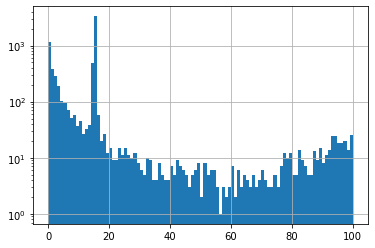

In [11]:
paper_dataset["fuelexp"].hist(bins=100).set_yscale('log')

In [12]:
#paper_dataset["fuel"].hist(bins=100).set_yscale('log')

In [13]:
#paper_dataset[paper_dataset["oil"] == 1]["fuelexp"].hist(bins=100).set_yscale('log')

In [14]:
#paper_dataset[paper_dataset["oil"] == 0]["fuelexp"].hist(bins=100).set_yscale('log')

In [15]:
#paper_dataset[paper_dataset["oil"] == 1]["fuel"].hist(bins=100).set_yscale('log')

In [16]:
#paper_dataset[paper_dataset["oil"] == 0]["fuelexp"].hist(bins=100).set_yscale('log')

In [17]:
# cid uniquely identifies a country, however in some cases when a country splits we have the 
# same CID for 2 different names in different years. This might be solved by joining on (year, cid)

paper_data_countries = pd.read_stata(ORIGINAL_PAPER_COUNTRY, columns=["country", "cid", "year"]).drop_duplicates()
#paper_data_countries.sample(10)
#paper_data_countries[paper_data_countries[["year", "cid"]].duplicated(keep=False)]

#paper_data_countries[paper_data_countries["country"] == "Czechoslovakia"]

In [18]:
# Note to future selves: we lost Korea 1945-1949
paper_data_merged = paper_data_countries.merge(paper_dataset, on=["cid", "year"])

In [19]:
paper_data_merged.sample(5)

,country,cid,year,Unnamed: 0,atwards,X,id,cowcode,warstds,ptime,...,decade1,decade2,decade3,decade4,independ,tip,anocracy,proxregc,sxpnew.2,sxpsq.2
849,Bulgaria,23.0,1993.0,850,0,1281,20.0,355,0,588,...,0,0,0,1,1,71.0,0,6.250000e-02,0.094175,0.094175
2012,Ethiopia,50.0,1992.0,2013,0,2792,43.0,530,0,372,...,0,0,0,1,1,0.0,1,1.000000e+00,-1.169919,-1.169919
4926,Panama,117.0,1997.0,4927,0,6549,105.0,95,0,636,...,0,0,0,1,1,78.0,0,6.100000e-05,-0.934086,-0.934086
2199,Gabon,54.0,1995.0,2200,0,3019,47.0,481,0,432,...,0,0,0,1,1,35.0,1,1.562500e-02,4.099064,4.099064
4749,Norway,114.0,1960.0,4750,0,6344,102.0,385,0,192,...,1,0,0,0,1,56.0,0,3.010000e-36,0.090887,0.090887


In [20]:
paper_data_merged[["country", "fuelexp", "year"]].sample(5)

,country,fuelexp,year
4687,Niger,15.613734,1995.0
3923,Malawi,0.038530,1975.0
1883,Egypt,43.734489,1993.0
6593,Russia,14.994633,1993.0
227,Argentina,10.372510,1996.0


#### Heatmaps

In [21]:
def plot_val_by_country_year(df, val, years=None):
    pivot = pd.pivot_table(data=df, columns=["year"], index="country", values=[val])
    pivot.columns = [int(x[1]) for x in pivot.columns]
    
    if years:
        pivot_slice = pivot[years]
    else:
        pivot_slice = pivot
    
    plt.figure(figsize=(20, 40))
    ax = sns.heatmap(pivot_slice, cmap='RdYlGn_r', linewidths=0.5)
    ax.set_title(val)
    plt.savefig(f"img/year_heatmap_{val}")
    plt.show()

Some years had clearly invalid data in the heatmaps, so we removed them (see the `years=range(...)` parameter)

In [22]:
if CFG["plot_heatmaps"]:
    plot_val_by_country_year(paper_data_merged, "fuelexp", years=range(1964, 2001))
    plot_val_by_country_year(paper_data_merged, "illiteracy", years=range(1971, 2001))
    plot_val_by_country_year(paper_data_merged, "infant", years=range(1966, 2001))
    plot_val_by_country_year(paper_data_merged, "life", years=range(1961, 2001))
    #plot_val_by_country_year(paper_data_merged, "oil", years=range(1961, 2001))
    #plot_val_by_country_year(paper_data_merged, "gdpgrowth")

## Data wrangling for wars in territories

1. Get a row for each territory there was a war in for each year
2. For each country that was at war, match name with existing database
2. We need some data cleaning: US never had a war in its territory!
3. For each year, add a 'war in' column in the existing database for each country + intensity level


In [23]:
# 1 extra-systemic (state vs non-state in state territory to keep control of the system) <- colonies
# 2 inter-state  
# 3 intra-state
# 4 intra-state internationalized

In [24]:
# In this case, war is fought in location : we got this
ucdp_prio_data[ucdp_prio_data.type_of_conflict == 1].sample(5)

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
1045,279,Guinea-Bissau,Guinea-Bissau,1968,1,1,1
797,254,Cameroon,Cameroon,1957,1,0,1
517,229,Malaysia,Malaya,1949,1,1,1
719,241,Kenya,Kenya,1953,2,1,1
1004,273,Brunei,North Borneo,1962,1,0,1


In [25]:
# Not clear where the conflict was: however, only 48 conflicts: we can classify manually
ucdp_prio_data[ucdp_prio_data.type_of_conflict == 2]

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
2,11343,"Egypt, Israel",Suez/Sinai,1967,2,1,2
3,11343,"Egypt, Israel",Suez/Sinai,1969,1,1,2
4,11343,"Egypt, Israel",Suez/Sinai,1970,1,1,2
5,11343,"Egypt, Israel",Suez/Sinai,1973,2,1,2
31,11348,"South Sudan, Sudan",Common border,2012,1,0,2
...,...,...,...,...,...,...,...
2277,409,"Eritrea, Ethiopia",Common border,2016,1,1,2
2354,420,"Australia, Iraq, United Kingdom, United States...",NaN,2003,2,1,2
2401,427,"Tanzania, Uganda",Kagera Salient,1978,1,0,2
2414,431,"Afghanistan, Russia (Soviet Union)",NaN,1979,1,0,2


In [26]:
# In this case, war is fought in location : we got this
ucdp_prio_data[ucdp_prio_data.type_of_conflict == 3].sample(5)

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
1640,329,Ethiopia,Ogaden,1993,1,1,3
1125,287,Burundi,NaN,2014,1,1,3
1197,289,Colombia,NaN,1995,1,1,3
2230,398,Bosnia-Herzegovina,Croat,1994,1,1,3
487,227,India,NaN,1992,1,1,3


In [27]:
#ucdp_prio_data[(ucdp_prio_data.type_of_conflict == 3) & (ucdp_prio_data.intensity_level == 1) & (ucdp_prio_data.location == 'United Kingdom')]

In [28]:
#ucdp_prio_data[(ucdp_prio_data.type_of_conflict != 2) & (ucdp_prio_data.location.str.contains('United States'))]

In [29]:
# Idea: always match countries with others that have the same intensity of war. Keep all intensities. 

## Selecting useful columns from datasets and merging on conflict id
To know the geographic location of war we merge the UCDP/PRIO dataset with the disgregated dataset (ged-201) in order to have a new dataset with important information for data analysis. So we did a filtering on the columns of the two datasets and we merged using the feature conflic_id_new, for the disgregated dataset, and the feature conflict_id for the UCDP/PRIO dataset. These two features are fully compatible and identify a specific conflict.
Using the UCDP dataset we select conflicts with types of conflict equal to 1, 3 or 4 (extrasystemic, intrastate, internationalzed intrastate) because in these cases the location corresponds to the geografic location which is not true in general. For conflicts of type 2 (interstates) we use the merging as described above for conflicts starting from 1989, for the others we classify the geographic location manually using the geografic area.

In [30]:
# GED_201 contains data from 1989 onwards
ged_201['year'].min()

1989

#### Selecting conflicts of types (1,3,4)

Select conflicts of type 1, 3 and 4 between 1961 and 2000 where "location" means geographic location.

In [31]:
# Filter years between 1961 and 2000
ucdp_prio_data_1961_2000 = ucdp_prio_data[(ucdp_prio_data['year']>1960) & (ucdp_prio_data['year']<=2000)]
# filter conflicts of type 1, 3, 4 between 1961 and 2000
ucdp_prio_data_134 = ucdp_prio_data_1961_2000[ucdp_prio_data_1961_2000['type_of_conflict'] != 2]

#### Selecting conflicts of type 2 after the 1989

In [32]:
# filter conflicts of type 2 between 1961 and 2000
ucdp_prio_data_2 = ucdp_prio_data_1961_2000[ucdp_prio_data_1961_2000['type_of_conflict'] == 2]

In [33]:
# view conflicts of type 2 between 1961 and 2000
ucdp_prio_data_2[ucdp_prio_data_2['year']>1988].head()

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
291,218,"India, Pakistan",Kashmir,1989,1,1,2
292,218,"India, Pakistan",Kashmir,1990,1,1,2
293,218,"India, Pakistan",Kashmir,1991,1,1,2
294,218,"India, Pakistan",Kashmir,1992,1,1,2
295,218,"India, Pakistan",Kashmir,1996,1,1,2


In [34]:
# merging with ged_201 to have the geographical location for conflicts after 1989
ucdp_2_after1989 = pd.merge(ged_201, ucdp_prio_data_2, 
                            left_on= ['conflict_new_id','year'], 
                            right_on =['conflict_id','year']).drop_duplicates()

In [35]:
# drop "location" and "conflict_new_id", then rename country to "location". 
# Now location is geographical location

ucdp_2_drop_cols = ["conflict_new_id", "location"]
if all([col in ucdp_2_after1989 for col in ucdp_2_drop_cols]):
    ucdp_2_after1989.drop(ucdp_2_drop_cols, axis=1, inplace=True)
    print(f"Dropped: {ucdp_2_drop_cols}")

ucdp_2_after1989.rename(columns = {"country" : "location"}, inplace=True)
ucdp_2_after1989.sample(5)

Dropped: ['conflict_new_id', 'location']


,year,location,conflict_id,territory_name,intensity_level,cumulative_intensity,type_of_conflict
172,2000,India,218,Kashmir,1,1,2
86,1997,India,218,Kashmir,1,1,2
3,1995,Ecuador,403,Cordillera del Condor,1,0,2
75,1991,Pakistan,218,Kashmir,1,1,2
51,1999,Ethiopia,409,Common border,2,1,2


#### Selecting manually the location of interstate conflicts (2) before 1989

In [36]:
# before 1970
ucdp_before_1970 = ucdp_prio_data_2[ucdp_prio_data_2['year'] < 1970].copy()
ucdp_before_1970["location"] = ucdp_before_1970["location"].str.split(', ') # split on comma
ucdp_before_1970_exp = ucdp_before_1970.explode("location") # explode split rows

ucdp_before_1970_exp.index = range(2500, 2500+len(ucdp_before_1970_exp)) # reassign index 
ucdp_before_1970_exp.sample(5) 

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
2539,301,Jordan,West Bank,1967,2,1,2
2529,293,Vietnam (North Vietnam),South Vietnam,1965,2,1,2
2531,293,Vietnam (North Vietnam),South Vietnam,1966,2,1,2
2534,293,South Vietnam,South Vietnam,1968,2,1,2
2514,274,China,"Aksai Chin, Arunachal Pradesh",1967,1,1,2


In [37]:
# Drop countries where the war did not take place
udcp_before_1970_manual = ucdp_before_1970_exp.drop([
    2501, # Israel Suez
    2503, # Israel Suez
    2509, # Somalia Ogaden
    2510, # France 1961 (vs Tunisia)
    2517, # France 1961 (vs Tunisia)
    2529, # North Vietnam 1965
    2531, # North Vietnam 1965
    2533, # North Vietnam 1965
    2535, # North Vietnam 1965
    2537, # North Vietnam 1965
    2540, # Israel Golan
])

In [38]:
# Same as above for conflicts between 1980 and 1988
df_1988 = ucdp_prio_data[(ucdp_prio_data.type_of_conflict == 2) & (ucdp_prio_data.year >= 1980) & (ucdp_prio_data.year<=1988)].copy()
df_1988["location"] = df_1988["location"].str.split(', ')
df_1988_exploded = df_1988.explode("location")
df_1988_exploded.index = range(2700, 2700+len(df_1988_exploded))
udcp_before_1988_manual = df_1988_exploded.drop([2739, 2743, 2707])

In [39]:
# Same as above for conflicts between 1970 and 1980
ucdp_before_1980 = ucdp_prio_data_2[(ucdp_prio_data_2['year']>1970) & (ucdp_prio_data_2['year']<1980)].copy()
ucdp_before_1980["location"] = ucdp_before_1980["location"].str.split(', ')
ucdp_before_1980_exp = ucdp_before_1980.explode("location")
ucdp_before_1980_exp.index = list(range(2600, 2600+len(ucdp_before_1980_exp)))
ucdp_before_1980_manual = ucdp_before_1980_exp.drop([2601 # Israel Suez
                           ,2605 # Somalia Ogaden
                           ,2607,# Somalia Ogaden
                           2609, # Somalia Ogaden
                           2611, #North Vietnam
                           2613, #North Vietnam
                           2615, #North Vietnam
                           2617, #North Vietnam
                           2622, #Israel Golan
                           2629, #Turkey north cyprus
                           2645, #Uganda Kagera Salient
                           2647, #Russia
                          ])

In [40]:
# concatenate all conflicts of level 2
ucdp_manual = pd.concat([udcp_before_1970_manual, ucdp_before_1980_manual, udcp_before_1988_manual])
ucdp_conflict_level2 = pd.concat([ucdp_manual, ucdp_2_after1989])
ucdp_conflict_level2.sample(5)

,conflict_id,location,territory_name,year,intensity_level,cumulative_intensity,type_of_conflict
2511,272,Tunisia,Bizerte,1961,2,1,2
2515,274,India,"Aksai Chin, Arunachal Pradesh",1967,1,1,2
2718,324,Iran,Various,1986,2,1,2
2527,281,Malaysia,North Borneo,1966,1,0,2
2612,293,South Vietnam,South Vietnam,1973,2,1,2


In [41]:
# concatenate all conflicts
filtercols = ["location", "year", "conflict_id", "intensity_level", 
              "cumulative_intensity", "territory_name"]#, "region"]
ucdp_wrangled = pd.concat([ucdp_prio_data_134, ucdp_conflict_level2])[filtercols].sort_values(by="year")

ucdp_wrangled.sample(5)

,location,year,conflict_id,intensity_level,cumulative_intensity,territory_name
555,Myanmar (Burma),1963,231,2,1,Kachin
1663,Indonesia,1976,330,2,1,East Timor
582,Myanmar (Burma),1990,231,1,1,Kachin
957,Nepal,1962,269,1,0,NaN
1693,Morocco,1988,331,1,1,Sahrawi Arab Democratic Republic (Western Sahara)


In [42]:
# Standardize names
name_map = {
    "Bosnia" : "Bosnia-Herzegovina",
    "Cambodia (Kampuchea)" : "Cambodia",
    "Congo" : "Congo (Braz)",
    "Zaire/Congo" : "DR Congo (Zaire)",
    "Guinea Bissau" : "Guinea-Bissau",
    "Papua NG" : "Papua New Guinea",
    "Madagascar (Malagasy)" : "Madagascar",
    "Myanmar/Burma" : "Myanmar (Burma)",
    "USSR/Russia" : "Russia (Soviet Union)",
    "Serbia (Yugoslavia)" : "Yugoslavia",
    "Trinidad" : "Trinidad and Tobago",
    "United Kingdom" : "U.K.",
    "Yemen (North Yemen)" : "Yemen", # TODO: review
    "South Yemen" : "Yemen", # TODO: review
    "Zimbabwe (Rhodesia)" : "Zimbabwe",
    "Vietnam (North Vietnam)" : "Vietnam"
}


# substitute names
#paper_features = ["country", "life", "fuelexp", "year", "illiteracy", "infant"]
#paper_wellbeing = paper_data_merged[paper_features].copy()
paper_wellbeing = paper_data_merged # rename
paper_wellbeing.country = [name_map.get(x, x) for x in paper_wellbeing.country]
ucdp_wrangled.location = [name_map.get(x, x) for x in ucdp_wrangled.location]

# year as int
paper_wellbeing.year = paper_wellbeing.year.astype(int)

# rename Vietnam before unification to South Vietnam
# Data before unification is very likely only from South Vietnam
vietnam_index = paper_wellbeing[(paper_wellbeing["country"] == "Vietnam") & (paper_wellbeing["year"] < 1976)].index
paper_wellbeing.loc[vietnam_index, "country"] = "South Vietnam"

In [43]:
# drop North Vietnam before 1976
dropped_vietnam = False
if not dropped_vietnam:
    ucdp_wrangled.drop([2639, 2633], inplace=True)
    dropped_vietnam = True

In [44]:
# change Russia to USSR in 1990 and 1991 (this is likely a mistake)
russia_index = paper_wellbeing[(paper_wellbeing["country"] == "Russia") & (paper_wellbeing["year"] <= 1991)].index
paper_wellbeing.loc[russia_index, "country"] = "Russia (Soviet Union)"

# change USSR after 1992 to Russia
ussr_index = ucdp_wrangled[(ucdp_wrangled["location"] == "Russia (Soviet Union)") & (ucdp_wrangled["year"] > 1991)].index
ucdp_wrangled.loc[ussr_index, "location"] = "Russia"

In [45]:
ucdp_paper_outerjoin = paper_wellbeing.merge(ucdp_wrangled, how='outer', 
                                             left_on=["country", "year"], 
                                             right_on=["location", "year"])
ucdp_paper_outerjoin.sample(5)

,country,cid,year,Unnamed: 0,atwards,X,id,cowcode,warstds,ptime,...,tip,anocracy,proxregc,sxpnew.2,sxpsq.2,location,conflict_id,intensity_level,cumulative_intensity,territory_name
6031,South Africa,136.0,1947,5649.0,0.0,7563.0,124.0,560.0,0.0,36.0,...,28.000000,1.0,1.000000e+00,0.093175,0.093175,NaN,NaN,NaN,NaN,NaN
3177,Iraq,72.0,1955,2993.0,0.0,3987.0,66.0,645.0,0.0,132.0,...,24.000000,1.0,8.670000e-19,0.096330,0.096330,NaN,NaN,NaN,NaN,NaN
6815,Turkey,152.0,1995,6418.0,1.0,8507.0,144.0,640.0,0.0,475.0,...,17.893057,0.0,2.380000e-07,-1.091940,-1.091940,Turkey,383.0,1.0,0.0,NaN
1485,Costa Rica,37.0,1987,1468.0,0.0,2059.0,34.0,94.0,0.0,514.0,...,68.000000,0.0,0.000000e+00,0.440832,0.440832,NaN,NaN,NaN,NaN,NaN
4282,Malta,98.0,1996,4067.0,0.0,5484.0,86.0,338.0,0.0,396.0,...,32.000000,0.0,1.395589e-01,-1.348326,-1.348326,NaN,NaN,NaN,NaN,NaN


In [46]:
# check which names in ucdp_wrangled and paper_wellbeing don't overlap
x = ucdp_paper_outerjoin.country.unique().astype(str)
y = ucdp_paper_outerjoin.location.unique().astype(str)
print("in paper_wellbeing, not in ucdp_wrangled:\n", np.setdiff1d(x, y))
print("in ucdp_wrangled, not in paper_wellbeing:\n", np.setdiff1d(y, x))

in paper_wellbeing, not in ucdp_wrangled:
 ['Albania' 'Armenia' 'Australia' 'Austria' 'Bahamas' 'Bahrain' 'Barbados'
 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Botswana' 'Brazil'
 'Bulgaria' 'C.A.R.' 'Canada' 'Cape Verde' 'Costa Rica' 'Czech Republic'
 'Czechoslovakia' 'Denmark' 'Estonia' 'Fiji' 'Finland' 'Germany' 'Greece'
 'Guyana' 'Hungary' 'Iceland' 'Ireland' 'Italy' 'Ivory Coast' 'Jamaica'
 'Japan' 'Kazakhstan' 'Korea, South' 'Kyrgyzstan' 'Latvia' 'Lithuania'
 'Luxembourg' 'Macedonia' 'Malawi' 'Malta' 'Mauritius' 'Mongolia'
 'Namibia' 'Netherlands' 'New Zealand' 'Norway' 'Poland' 'Portugal'
 'Qatar' 'Seychelles' 'Singapore' 'Slovakia' 'Slovenia' 'Solomon Islands'
 'Swaziland' 'Sweden' 'Switzerland' 'Taiwan' 'Turkmenistan' 'U.A.R.'
 'U.S.A.' 'Ukraine' 'Vanuatu' 'Western Samoa' 'Yemen AR' 'Yemen PR'
 'Zambia']
in ucdp_wrangled, not in paper_wellbeing:
 ['Brunei']


In [47]:
# copy location column to country when country is null, then drop location
joined = ucdp_paper_outerjoin.copy()
joined.loc[joined.country.isnull(), "country"] = joined.loc[joined.country.isnull(), "location"]

# drop location
if "location" in joined:
    joined.drop("location", inplace=True, axis=1)
    print("Done")

Done


In [48]:
# add new binary column for when the country is at war
# NOTE: "war" in this case is generic war of any type

joined["war"] = (~joined.conflict_id.isnull()).astype(int)
joined.sample(5)

,country,cid,year,Unnamed: 0,atwards,X,id,cowcode,warstds,ptime,...,tip,anocracy,proxregc,sxpnew.2,sxpsq.2,conflict_id,intensity_level,cumulative_intensity,territory_name,war
5545,Poland,122.0,1984,5163.0,0.0,6816.0,110.0,290.0,0.0,480.0,...,67.0,0.0,1.360000e-20,-0.929465,-0.929465,NaN,NaN,NaN,NaN,0
3973,Libya,90.0,1965,3762.0,0.0,5005.0,171.0,620.0,0.0,180.0,...,14.0,0.0,5.960000e-08,0.089129,0.089129,NaN,NaN,NaN,NaN,0
1746,Dominican Republic,44.0,1950,1729.0,0.0,2414.0,39.0,42.0,0.0,72.0,...,27.0,0.0,1.000000e+00,0.089795,0.089795,NaN,NaN,NaN,NaN,0
4781,Nepal,108.0,1947,4431.0,0.0,5995.0,96.0,790.0,0.0,36.0,...,28.0,1.0,1.000000e+00,0.094209,0.094209,NaN,NaN,NaN,NaN,0
7160,Vanuatu,162.0,1995,6761.0,0.0,9067.0,151.0,935.0,0.0,180.0,...,14.0,0.0,1.392610e-01,-0.506331,-0.506331,NaN,NaN,NaN,NaN,0


## Income inequality

In [49]:
import glob
ineq_csv_files = glob.glob(WID_DATA_FOLDER + '/*_data*.csv')

wid_gini_usecols = ["country", "year", "variable", "value"]
ineq_df_list = [pd.read_csv(csv, sep=';', keep_default_na=False, usecols=wid_gini_usecols) 
                for csv in ineq_csv_files]

In [50]:
# get country indices
ineq_countries = pd.read_csv(WID_DATA_FOLDER + '/WID_countries.csv', sep=';', usecols=["alpha2", "shortname"])
ineq_countries_map = {code : name for code, name in zip(ineq_countries["alpha2"], ineq_countries["shortname"])}
ineq_countries_map

{'AM': 'Armenia',
 'AN': 'Netherlands Antilles',
 'AO': 'Angola',
 'AR': 'Argentina',
 'AS': 'American Samoa',
 'AT': 'Austria',
 'AU': 'Australia',
 'AW': 'Aruba',
 'AZ': 'Azerbaijan',
 'BA': 'Bosnia and Herzegovina',
 'BB': 'Barbados',
 'BD': 'Bangladesh',
 'BE': 'Belgium',
 'BF': 'Burkina Faso',
 'BG': 'Bulgaria',
 'BH': 'Bahrain',
 'BI': 'Burundi',
 'BJ': 'Benin',
 'BM': 'Bermuda',
 'BN': 'Brunei Darussalam',
 'BO': 'Bolivia',
 'BR': 'Brazil',
 'BS': 'Bahamas',
 'BT': 'Bhutan',
 'BW': 'Botswana',
 'BY': 'Belarus',
 'BZ': 'Belize',
 'CA': 'Canada',
 'CD': 'DR Congo',
 'CF': 'Central African Republic',
 'CG': 'Congo',
 'CH': 'Switzerland',
 'CI': "Cote d'Ivoire",
 'CK': 'Cook Islands',
 'CL': 'Chile',
 'CM': 'Cameroon',
 'CN': 'China',
 'CN-RU': 'Rural China',
 'CN-UR': 'Urban China',
 'CO': 'Colombia',
 'CR': 'Costa Rica',
 'CS': 'Czechoslovakia',
 'CU': 'Cuba',
 'CV': 'Cabo Verde',
 'CW': 'Curacao',
 'CY': 'Cyprus',
 'CZ': 'Czech Republic',
 'DD': 'German Democratic Republic',
 'DE

In [51]:
ineq_full_raw = pd.concat(ineq_df_list) # join all files

# filter interesting rows
ineq_gini = ineq_full_raw[(ineq_full_raw["variable"] == "gptinc992j") & 
                          (ineq_full_raw["year"] > 1960) & 
                          (ineq_full_raw["year"] <= 2000)].copy()

del ineq_full_raw # free up some memory
ineq_gini.sample(5)

,country,variable,year,value
35653,OM,gptinc992j,1997,0.673781
145398,IN,gptinc992j,1982,0.396548
32265,EE,gptinc992j,1992,0.495801
28126,LV,gptinc992j,1997,0.497542
18360,XR,gptinc992j,1982,0.280036


In [52]:
# rename country code with country names
ineq_gini.country = [ineq_countries_map.get(c, c) for c in ineq_gini.country]

# rename gini column
ineq_gini.rename(columns = {"value" : "gini"}, inplace=True)

# drop "variable column"
if "variable" in ineq_gini:
    ineq_gini.drop("variable", axis=1, inplace=True)
    print("Done")

ineq_gini.sample(5)

Done


,country,year,gini
115151,Finland,1991,0.353309
81431,Russian Federation,1961,0.354157
29005,Luxembourg,1995,0.454754
22094,Belgium,1993,0.436635
25572,Urban China,1979,0.239972


In [53]:
ineq_rename = {
    "Bosnia and Herzegovina" : "Bosnia-Herzegovina",
    "Cabo Verde" : "Cape Verde",
    "Central African Republic" : "C.A.R.",
    "Congo" : "Congo (Braz)",
    "DR Congo" : "DR Congo (Zaire)",
    "German Democratic Republic" : "Germany",
    "Russian Federation" : "Russia",
    "Syrian Arab Republic" : "Syria",
    "USA" : "U.S.A.",
    "United Kingdom" : "U.K.",
    "United Arab Emirated" : "U.A.R.",
    "Cote d'Ivoire" : "Ivory Coast"
}
ineq_gini.country = [ineq_rename.get(c, c) for c in ineq_gini.country]

In [54]:
x = ineq_gini.country.unique().astype(str)
y = joined.country.unique().astype(str)
print("in ineq_gini, not in joined:\n", np.setdiff1d(x, y))
print("in joined, not in ineq_gini:\n", np.setdiff1d(y, x))

in ineq_gini, not in joined:
 ['Africa' 'Asia (excl. Middle East)'
 'Asia (excluding Middle East), Market Exchange Rate' 'Eastern Africa'
 'Eastern Europe' 'Equatorial Guinea' 'Europe' 'European Union'
 'Latin America' 'Latin America, Market Exchange Rate' 'Middle Africa'
 'Middle East' 'Middle East and Northern Africa'
 'Middle East and Northern Africa, Market Exchange Rate' 'Montenegro'
 'Northern Africa' 'Northern America' 'Oceania' 'Palestine' 'Rural China'
 'Russia and Ukraine' 'Russia and Ukraine, Market Exchange Rate'
 'Sao Tome and Principe' 'Serbia' 'Southern Africa' 'Sub-Saharan Africa'
 'Sub-Saharan Africa, Market Exchange Rate' 'United Arab Emirates'
 'Urban China' 'Western Africa' 'World' 'World (Market Exchange Rate)'
 'Zanzibar' 'nan']
in joined, not in ineq_gini:
 ['Afghanistan' 'Argentina' 'Armenia' 'Australia' 'Azerbaijan' 'Bahamas'
 'Bangladesh' 'Barbados' 'Belarus' 'Belize' 'Bhutan' 'Bolivia' 'Brazil'
 'Brunei' 'Cambodia' 'Canada' 'Chile' 'Colombia' 'Costa Rica' 'Cu

Lots of countries are missing a Gini coefficient! We should look for another dataset...

In [55]:
#final_df = joined.merge(ineq_gini, how='left', on=["country", "year"])

In [56]:
#for country in country2region:
#    idx = final_df[final_df["country"] == country].index
#    final_df.loc[idx, "gini"] = ineq_gini[ineq_gini["country"] == country2region[country]].gini

## 2nd Gini dataset

In [57]:
wiid_filtercols = ["country", "year", "gini_reported"]
wiid_gini_raw = pd.read_stata(DATA_FOLDER + 'WIID_06MAY2020.dta', columns=wiid_filtercols)

In [58]:
gini_years = wiid_gini_raw[(wiid_gini_raw.year > 1960) & (wiid_gini_raw.year <= 2000)].copy()
gini_years.sample(5)

,country,year,gini_reported
8367,Philippines,1994.0,42.89
4075,Gabon,1977.0,63.20
10984,United States,1979.0,36.58
4694,Honduras,1968.0,56.60
2537,Costa Rica,1992.0,45.71


In [59]:
#print(np.setdiff1d(final_df.country, gini_years.country))
#print(np.setdiff1d(gini_years.country, final_df.country))

In [60]:
# rename countries
gini_2_mapping = {
    'Bahamas, The' : 'Bahamas',
    'Bosnia and Herzegovina' : 'Bosnia-Herzegovina',
    'Central African Republic' : 'C.A.R.',
    "Cote d'Ivoire" : 'Ivory Coast',
    'Czechia' : 'Czech Republic',
    'Eswatini' : 'Swaziland',
    'Gambia, The' : 'Gambia',
    'Korea, Republic of' : 'Korea, South',
    'North Macedonia' : 'Macedonia',
    'Serbia and Montenegro' : 'Serbia',
    'Soviet Union' : 'Russia (Soviet Union)',
    'United Kingdom' : 'U.K.',
    'United States' : 'U.S.A.'
}

gini_years.country = gini_years.country.apply(lambda c : gini_2_mapping[c] if c in gini_2_mapping else c)

In [61]:
# Take mean of all reported gini values
gini_by_country_year = gini_years.groupby(['country', 'year']).mean()

# standardize gini units
gini_by_country_year.gini_reported = gini_by_country_year.gini_reported.apply(lambda x : x/100)

gini_by_country_year.reset_index(inplace=True)
gini_by_country_year.rename(columns = {"gini_reported" : "gini"}, inplace=True)


gini_by_country_year.sample(5)

,country,year,gini
676,Greece,1964.0,0.43900
147,Barbados,1970.0,0.39750
255,Bulgaria,1983.0,0.25000
396,Colombia,1989.0,0.53395
1412,Singapore,1981.0,0.43000


In [62]:
# join 1st and 2nd gini datasets
gini_final = pd.concat([ineq_gini, gini_by_country_year]).groupby(['country', 'year']).mean()
gini_final.reset_index(inplace=True)
gini_final.sample(5)

,country,year,gini
758,Denmark,1971.0,0.225000
821,Eastern Europe,1985.0,0.337453
2974,U.S.A.,1979.0,0.414937
352,Botswana,1988.0,0.720872
1087,Germany,1964.0,0.384750


In [63]:
# join with conflict data
final_df = joined.merge(gini_final, how='left', on=["country", "year"])
final_df.sample(5)

,country,cid,year,Unnamed: 0,atwards,X,id,cowcode,warstds,ptime,...,anocracy,proxregc,sxpnew.2,sxpsq.2,conflict_id,intensity_level,cumulative_intensity,territory_name,war,gini
7172,Venezuela,163.0,1951,6773.0,0.0,9079.0,152.0,101.0,0.0,84.0,...,1.0,9.540000e-07,0.092955,0.092955,NaN,NaN,NaN,NaN,0,NaN
2379,Germany,57.0,1992,2299.0,0.0,3184.0,50.0,255.0,0.0,576.0,...,0.0,5.170000e-26,-1.232849,-1.232849,NaN,NaN,NaN,NaN,0,0.333762
6507,Taiwan,145.0,1979,6115.0,0.0,8099.0,136.0,713.0,0.0,372.0,...,0.0,3.470000e-18,0.086528,0.086528,NaN,NaN,NaN,NaN,0,0.285000
6762,Turkey,152.0,1945,6368.0,0.0,8457.0,144.0,640.0,0.0,12.0,...,0.0,1.430244e-01,0.092087,0.092087,NaN,NaN,NaN,NaN,0,NaN
3339,Israel,74.0,1987,3135.0,1.0,4131.0,68.0,666.0,0.0,6.0,...,0.0,5.290000e-23,-1.133038,-1.133038,234.0,1.0,1.0,Palestine,1,0.482000


In [64]:
# deal with nans
final_df.intensity_level = final_df.intensity_level.apply(lambda x : 0 if np.isnan(x) else x)
final_df.cumulative_intensity = final_df.cumulative_intensity.apply(lambda x : 0 if np.isnan(x) else 1 if x == 1 else 2)

In [65]:
# rename wellbeing
wellbeing_features = ["life", "oil", "fuelexp", "war", "illiteracy", "infant", "intensity_level", "cumulative_intensity", "gini"]
used_columns = sorted(list(set(["ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst", "oil33"] + ["year", "country"]).union(set(wellbeing_features))))

Because many countries are missing Gini score values, we will do our analyses with and without the Gini score as a feature

In [66]:
# create a binary feature for countries that export more than 33% of GDP as fuel
final_df["oil33"] = (final_df["fuelexp"] > 33).astype(int)
df_gini = final_df[(final_df.year > 1960) & (final_df.year <= 2000)][used_columns]

df_gini_clean = df_gini.dropna() # dataset with 'gini' column, without nans

In [67]:
df_no_gini = df_gini.drop('gini', axis=1)
df_no_gini_clean = df_no_gini.dropna() # dataset without 'gini' column, without nans

# 1. Is oil correlated with a country's wellbeing?

Is there a correlation between abundance/high exports of oil in a country and its population's wellbeing?

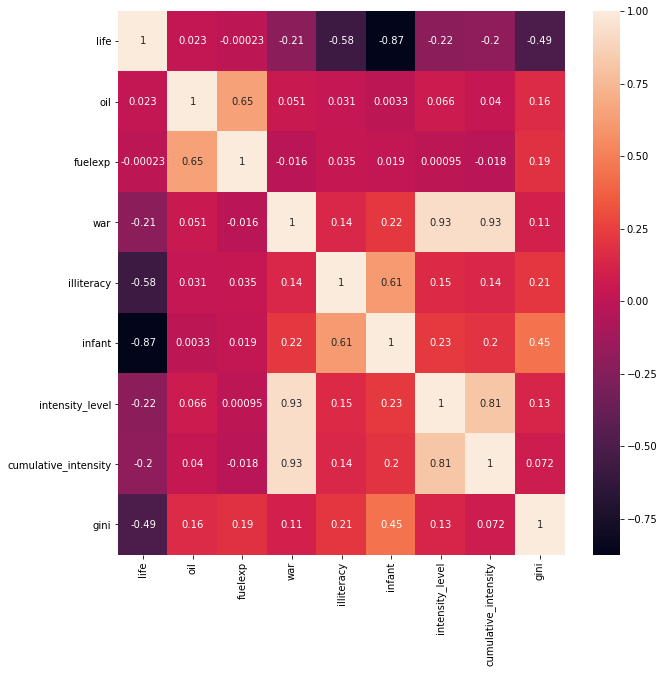

In [68]:
plt.figure(figsize=(10,10))
#df_part_1 = final_df[(final_df.year > 1960) & (final_df.year <= 2000)]
corrMatrix = final_df[wellbeing_features].corr()
sns.heatmap(corrMatrix, annot=True)
plt.savefig("img/heatmap")
plt.show()

With the current data, we can see no correlation between oil export and any of the variable that is an index of well-being. As a consequence, it does not make sense to look for causation.
The only possibly relevant feature is the gini index. Further integrations of the Gini score into the dataset may be necessary.

## 2. What are the variables that have the most influence in the prediction of a war?

1. Use random forests to predict a war in a country
3. Use the gini index to check the variables' importance - a la replication
4. If gini index seems to be relevant, integrate more data

intensity_level: nan -> 0
cumulative_intensity: 1 - > 2, 0 -> 1, nan -> 0

In [69]:
drop_cols = ['war', 'year', 'country', 'intensity_level', 'cumulative_intensity', 'milper', 'army85', 'sxpsq', 'elfo2', 'ef2']
x_df_no_gini = df_no_gini_clean.drop(drop_cols, axis=1)
y_df_no_gini = df_no_gini_clean.war
x_df_gini = df_gini_clean.drop(drop_cols, axis=1)
y_df_gini = df_gini_clean.war

In [70]:
df_no_gini_clean.war.values.sum()/len(df_no_gini_clean)

0.22898689677213166

In [71]:
df_gini_clean.war.values.sum()/len(df_gini_clean)

0.218609865470852

## Cross Validation

In [72]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.ensemble import  RandomForestClassifier

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x_df_no_gini, y_df_no_gini, test_size=0.2)

In [74]:
# TODO select variables on importance mass e.g. >= 25%

n_estimators_list = range(50, 450, 50) if CFG["cross_val"] else [100]

score_means = []

for e in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=e)
    scores = cross_val_score(rf, x_train, y_train, cv=10, scoring='f1')
    mean_score = np.mean(scores)
    score_means.append((rf, mean_score))
    print (f"n_estimators: {e}, mean score: {mean_score}")

rf_best, _ = max(score_means, key = lambda x : x[1])

n_estimators: 100, mean score: 0.8837193991985828


In [75]:
rf_best.fit(x_train, y_train)
rf_best.score(x_test, y_test)

0.950479233226837

In [76]:
f1_score(rf.predict(x_test), y_test)

0.888086642599278

In [77]:
list(reversed(sorted(list(zip(rf_best.feature_importances_, x_train.columns)))))[:25]

[(0.06724639863607197, 'sxpnew'),
 (0.05548846713083501, 'lpopns'),
 (0.04044723004674974, 'nmgdp'),
 (0.03603212934510514, 'ehet'),
 (0.034784679458703976, 'trade'),
 (0.03458860763599228, 'illiteracy'),
 (0.031136840213444462, 'numlang'),
 (0.028333650727321757, 'expgdp'),
 (0.025994704089068215, 'ptime'),
 (0.025110251478591885, 'agexp'),
 (0.02459160757773179, 'lmtnest'),
 (0.024457473471858508, 'popdense'),
 (0.023600053244033962, 'dlang'),
 (0.023092669181757196, 'ln_gdpen'),
 (0.022744660968978807, 'fuelexp'),
 (0.02038168024512175, 'drel'),
 (0.02002207424260101, 'infant'),
 (0.019674974883749606, 'warhist'),
 (0.01944144971825538, 'manuexp'),
 (0.019029114012267416, 'ager'),
 (0.018625425378075676, 'elfo'),
 (0.01837323828964531, 'second'),
 (0.016580807557614517, 'plural'),
 (0.016443154224369275, 'relfrac'),
 (0.015928049404895183, 'geo57')]

In [78]:
rf_notest = RandomForestClassifier()
rf_notest.fit(x_df_no_gini, y_df_no_gini)
top_N = 10
top_no_gini = [x[1] for x in 
               reversed(sorted(zip(rf_notest.feature_importances_, x_df_no_gini.columns), key = lambda x : x[0]))][:top_N]
top_no_gini

['sxpnew',
 'lpopns',
 'trade',
 'nmgdp',
 'illiteracy',
 'ehet',
 'expgdp',
 'numlang',
 'agexp',
 'ln_gdpen']

In [79]:
feature_imp_no_gini = rf_notest.feature_importances_
feature_names_no_gini = x_df_no_gini.columns

In [80]:
x_train, x_test, y_train, y_test = train_test_split(x_df_gini, y_df_gini, test_size=0.2)

In [81]:
n_estimators_list = range(50, 450, 50) if CFG["cross_val"] else [100]

score_means = []

for e in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=e)
    scores = cross_val_score(rf, x_train, y_train, cv=10, scoring='f1')
    mean_score = np.mean(scores)
    score_means.append((rf, mean_score))
    print (f"n_estimators: {e}, mean score: {mean_score}")

rf_best, _ = max(score_means, key = lambda x : x[1])

n_estimators: 100, mean score: 0.8604588383116708


In [82]:
rf_best.fit(x_train, y_train)
rf_best.score(x_test, y_test)

0.9160447761194029

In [83]:
f1_score(rf.predict(x_test), y_test)

0.8178137651821862

In [84]:
list(reversed(sorted(list(zip(rf_best.feature_importances_, x_train.columns)))))[:25]

[(0.06524397725310029, 'illiteracy'),
 (0.04120105891469761, 'trade'),
 (0.04029468885300911, 'lpopns'),
 (0.03613104468376328, 'sxpnew'),
 (0.03396762185951256, 'nmgdp'),
 (0.032781288994120944, 'ehet'),
 (0.03078043825258471, 'dlang'),
 (0.030519786293598642, 'ln_gdpen'),
 (0.029684592880388206, 'expgdp'),
 (0.02917382455503235, 'agexp'),
 (0.027136454597097445, 'numlang'),
 (0.025706203607812537, 'ef'),
 (0.02486930869900777, 'plural'),
 (0.022562370446217787, 'lmtnest'),
 (0.022109412953338032, 'popdense'),
 (0.021899372149364216, 'ptime'),
 (0.021550506906749794, 'elfo'),
 (0.02093347894011675, 'infant'),
 (0.020485874616602676, 'life'),
 (0.02013510127567172, 'fuelexp'),
 (0.018363444526035468, 'ager'),
 (0.01716383978499899, 'pri'),
 (0.017030317286631083, 'manuexp'),
 (0.01641950168774908, 'drel'),
 (0.014922808489128567, 'seceduc')]

In [85]:
rf_notest = RandomForestClassifier()
rf_notest.fit(x_df_gini, y_df_gini)
top_gini = [x[1] for x in 
            sorted(zip(rf_notest.feature_importances_, x_df_gini.columns), 
                   reverse=True, key = lambda x : x[0])][:top_N]
top_gini

['illiteracy',
 'sxpnew',
 'ehet',
 'lpopns',
 'numlang',
 'trade',
 'nmgdp',
 'dlang',
 'agexp',
 'expgdp']

In [86]:
feature_imp_gini = rf_notest.feature_importances_
feature_names_gini = x_df_gini.columns

In [87]:
np.sum(np.sort(rf_notest.feature_importances_)[::-1][:5])

0.23150987652616148

In [88]:
def get_features_by_mass(importances, names, mass=0.2):
    pairs = sorted(zip(importances, names), reverse=True, key = lambda x : x[0])
    
    acc = 0
    for i, (imp, name) in enumerate(pairs):
        acc += imp
        if acc >= mass:
            return pairs[:i + 1]
    return pairs

In [89]:
feature_imp_gini.max()

0.05878491677923273

In [90]:
get_features_by_mass(feature_imp_gini, feature_names_gini, mass=0.25)

[(0.05878491677923273, 'illiteracy'),
 (0.05073669161854537, 'sxpnew'),
 (0.04481677946921482, 'ehet'),
 (0.03926277165800112, 'lpopns'),
 (0.0379087170011674, 'numlang'),
 (0.036470449275025976, 'trade')]

## Matching

In [91]:
import statsmodels.formula.api as smf
import warnings
if CFG["nowarns"]:
    warnings.filterwarnings("ignore")
import pickle

In [92]:
def dump_match(match, name):
    with open(name, 'wb') as f:
        pickle.dump(match, f)
        
def load_match(name):
    with open(name, 'rb') as f:
        return pickle.load(f)

In [93]:
#Function to calculate bootstrap confidence intervals
def bootstrap_CI(data, nbr_draws, func, lo_qt=2.5, hi_qt=97.5):
    probs = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        probs[n] = func(data_tmp) # apply function

    return np.nanpercentile(probs, lo_qt), np.nanpercentile(probs, hi_qt), probs.mean()

In [94]:
#function that defines the absolute value of difference of propensity scores
def get_difference(propensity_score1, propensity_score2):
    return np.abs(propensity_score1-propensity_score2)


# function to get matching pairs in treatment and control group
def match_treatment_control(treatment_df, control_df, eps=0.05):
    
    matching={} # empty map to store matching pairs
    matched=set([]) # set to store matched elements from control group

    # iterate through treatment group first as it is the smallest one
    for treatment_id, treatment_row in treatment_df.iterrows():
        lowest_diff=eps
        for control_id, control_row in control_df.iterrows():
            if control_id in matched: 
                continue # skip matched elements


            # Calculate the difference 
            difference = get_difference(control_row['propensity_score'],
                                        treatment_row['propensity_score'])

            # match lowest difference in a greedy manner
            if difference<eps:
                if difference<lowest_diff:
                    matching[treatment_id]=control_id
                    lowest_diff=difference

        # add matched elements to set
        if lowest_diff!=eps: # check if at least one matching was found
            matched.add(matching[treatment_id])

    
    return matching

In [95]:
def matching_analysis(df, binary_var, feature_importances, feature_names, match_file, mass_threshold=0.25, intense_war=False, plothists=True):
    
    top_vars = [name for _, name in get_features_by_mass(feature_importances, feature_names, mass=mass_threshold)]
    print("Top variables according to mass threshold: ", top_vars)
    
    df_matching = df[set(top_vars).union([binary_var])]
    top_vars_no_fuelexp = [x for x in top_vars if x != "fuelexp"]
    
    formula = binary_var + ' ~ ' + ' + '.join(top_vars_no_fuelexp)
    print("Using formula: " + formula)
    mod = smf.logit(formula=formula, data=df_matching)

    res = mod.fit()

    # Extract the estimated propensity scores
    df_matching.loc[:, ('propensity_score')] = res.predict()
    
    treatment_df = df_matching[df_matching[binary_var] == 1]
    control_df = df_matching[df_matching[binary_var] == 0]
    
    try:
        print ("Loading match: ", match_file)
        matched = load_match(match_file)
    except FileNotFoundError:
        print ("Matching, this might take a while...")
        matched = match_treatment_control(treatment_df, control_df, eps=0.05)
        dump_match(matched, match_file)
        
    print (f"Number of matched elements: {len(matched)}")
        
    pair_control = control_df.loc[matched.values()]
    pair_treatment = treatment_df.loc[matched.keys()]
    
    if plothists:
        print ("Plotting!")
        for var in top_vars:
            fig, ax = plt.subplots(1, 2)
            fig.set_size_inches((16, 6))
            sns.distplot(treatment_df[var], hist=True, label='treated', ax=ax[0]);
            sns.distplot(control_df[var], hist=True, label='control', ax=ax[0])
            ax[0].set(title=f'{var} before matching',xlabel=var)
            ax[0].legend()
            sns.distplot(pair_treatment[var], hist=True, label='treated', ax=ax[1]);
            sns.distplot(pair_control[var], hist=True, label='control', ax=ax[1])
            ax[1].set(title=f'{var} after matching',xlabel=var)
            ax[1].legend()
            plt.show()
        
    # ATE
    
    war_var = 'war' if not intense_war else 'intensity_level'
    ate_features = ['war', 'intensity_level'] if intense_war else ['war']

    pair_treatment[ate_features] = df[ate_features].loc[pair_treatment.index]
    pair_control[ate_features] = df[ate_features].loc[pair_control.index]

    if intense_war:
        pair_treatment['intense_war'] = pair_treatment['intensity_level'].apply(lambda i: max(i-1,0))
        pair_control['intense_war'] = pair_control['intensity_level'].apply(lambda i: max(i-1,0))

    
    differences_y = pair_treatment[war_var].values - pair_control[war_var].values
    ATE = np.mean(differences_y)
    lo_ATE, up_ATE, _ = bootstrap_CI(differences_y, 1000, lambda x : x.mean(), lo_qt=2.5, hi_qt=97.5)

    print(f"ATE is equal to: {ATE:.3}, the 95%-confidence interval is ({lo_ATE:.3},{up_ATE:.3})")

Top variables according to mass threshold:  ['sxpnew', 'lpopns', 'trade', 'nmgdp', 'illiteracy', 'ehet']
Using formula: oil33 ~ sxpnew + lpopns + trade + nmgdp + illiteracy + ehet
Optimization terminated successfully.
         Current function value: 0.238827
         Iterations 7
Loading match:  nogini.pickle
Number of matched elements: 365
Plotting!


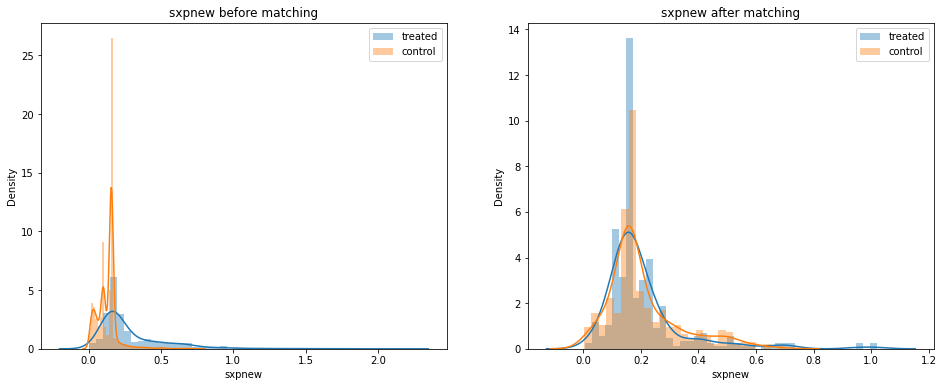

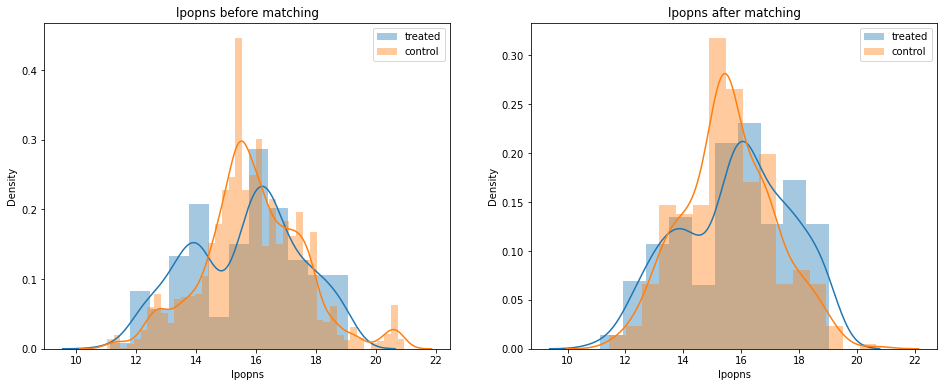

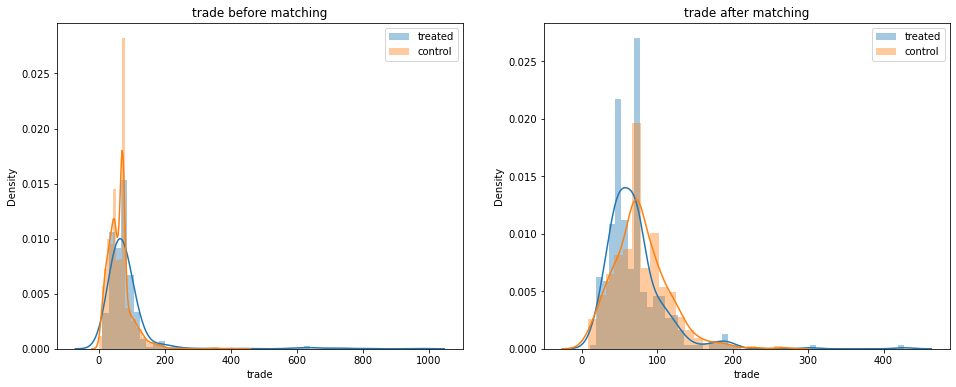

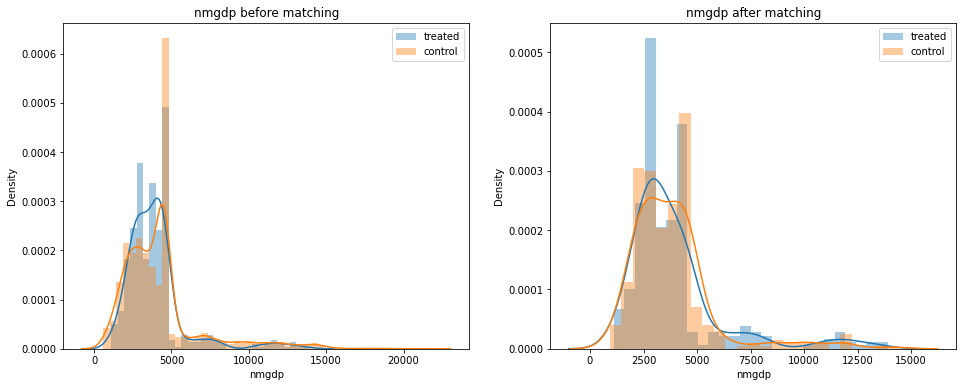

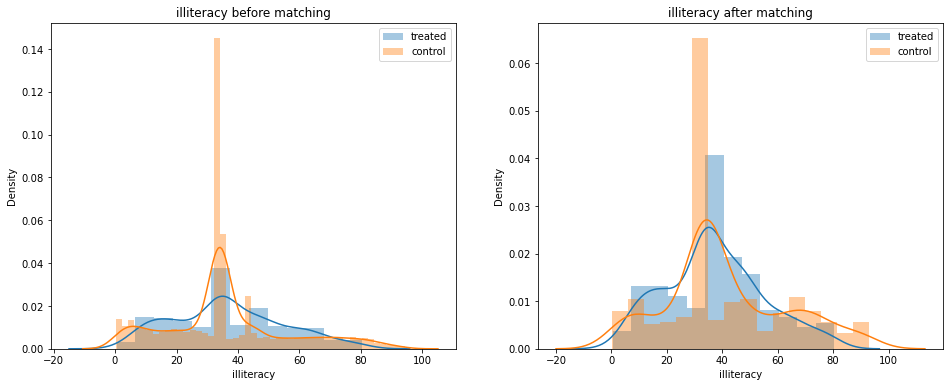

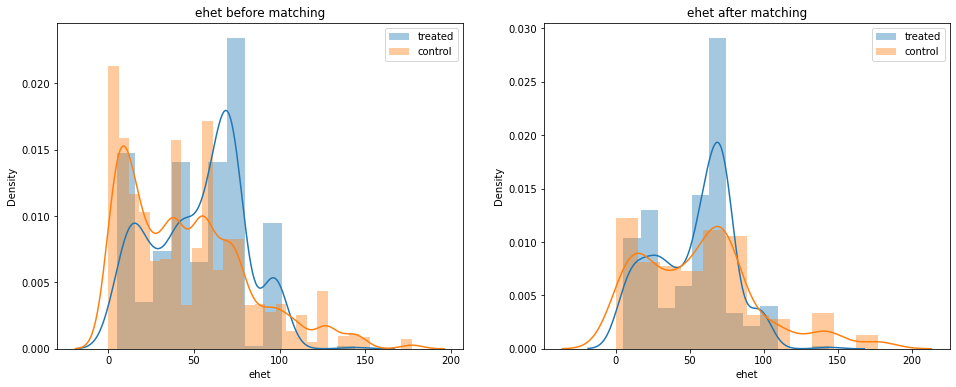

ATE is equal to: 0.178, the 95%-confidence interval is (0.123,0.233)


In [96]:
matching_analysis(df_no_gini_clean, 'oil33', feature_imp_no_gini, feature_names_no_gini, "nogini.pickle")

In [97]:
matching_analysis(df_no_gini_clean, 'oil33', feature_imp_no_gini, feature_names_no_gini, "nogini.pickle", plothists=False, intense_war=True)

Top variables according to mass threshold:  ['sxpnew', 'lpopns', 'trade', 'nmgdp', 'illiteracy', 'ehet']
Using formula: oil33 ~ sxpnew + lpopns + trade + nmgdp + illiteracy + ehet
Optimization terminated successfully.
         Current function value: 0.238827
         Iterations 7
Loading match:  nogini.pickle
Number of matched elements: 365
ATE is equal to: 0.26, the 95%-confidence interval is (0.184,0.34)


Top variables according to mass threshold:  ['sxpnew', 'lpopns', 'trade', 'nmgdp', 'illiteracy', 'ehet']
Using formula: oil ~ sxpnew + lpopns + trade + nmgdp + illiteracy + ehet
Optimization terminated successfully.
         Current function value: 0.345253
         Iterations 7
Loading match:  nogini_oil.pickle
Number of matched elements: 778
Plotting!


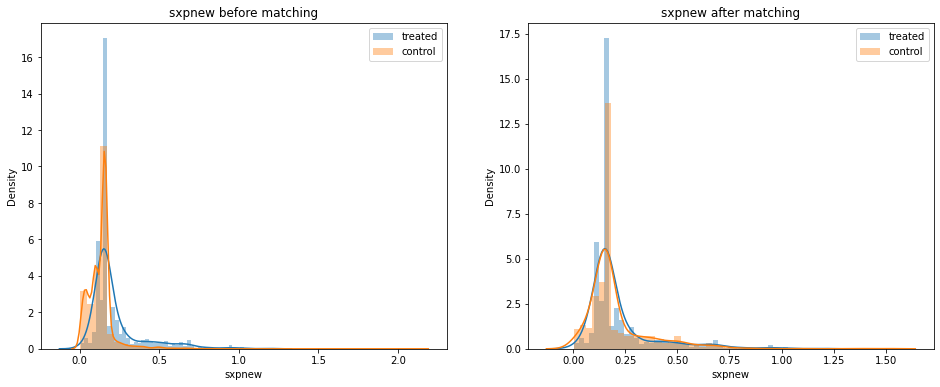

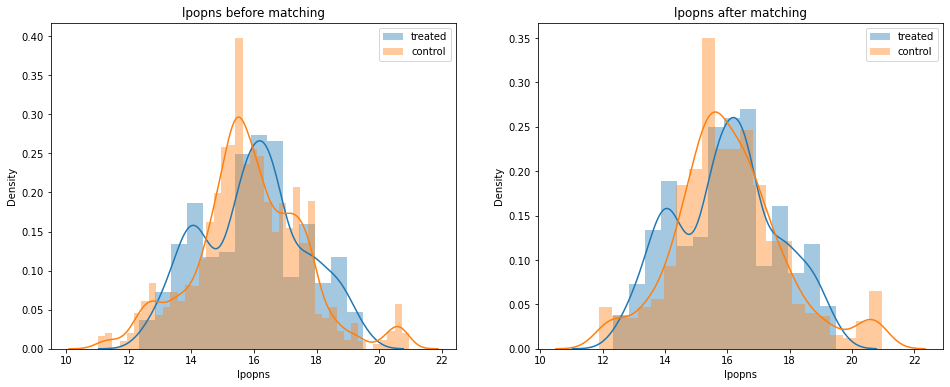

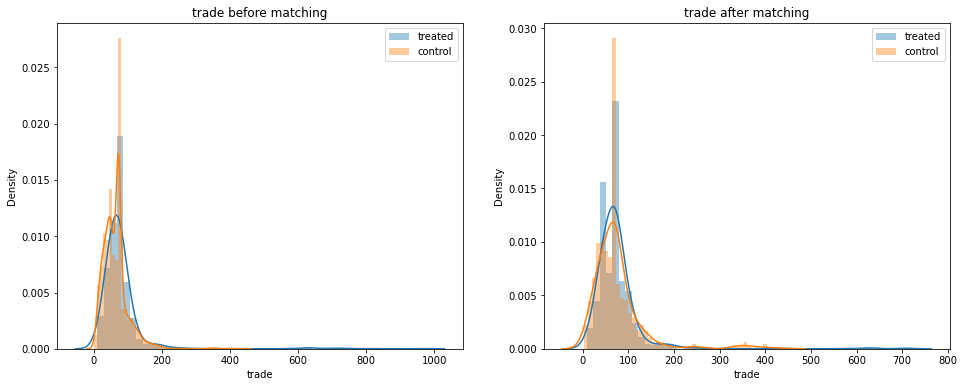

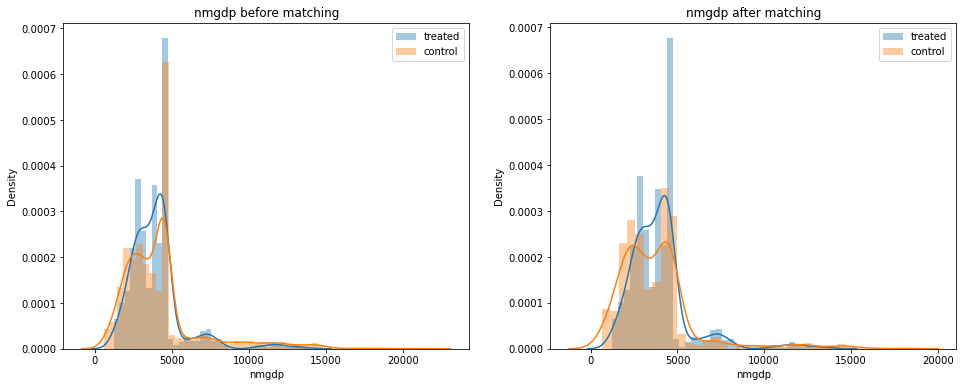

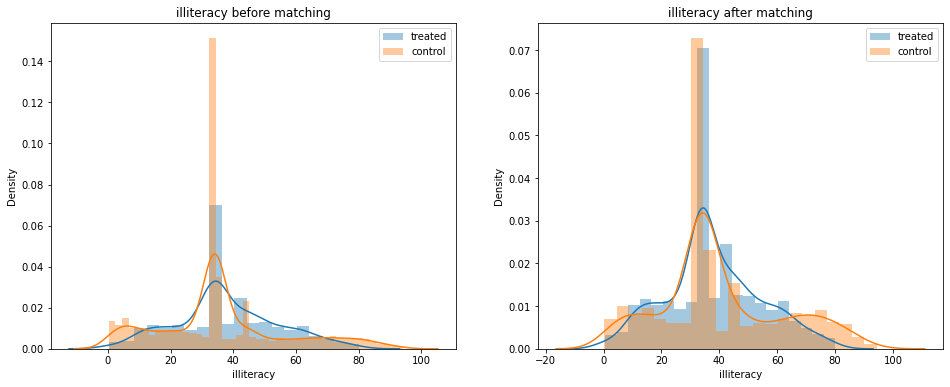

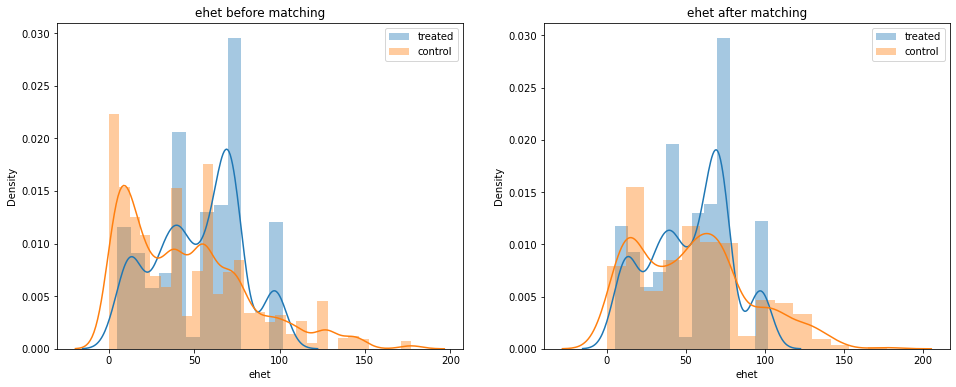

ATE is equal to: 0.0938, the 95%-confidence interval is (0.054,0.135)


In [98]:
matching_analysis(df_no_gini_clean, 'oil', feature_imp_no_gini, feature_names_no_gini, "nogini_oil.pickle")

In [99]:
matching_analysis(df_no_gini_clean, 'oil', feature_imp_no_gini, feature_names_no_gini, 
                  "nogini_oil.pickle", intense_war=True, plothists=False)

Top variables according to mass threshold:  ['sxpnew', 'lpopns', 'trade', 'nmgdp', 'illiteracy', 'ehet']
Using formula: oil ~ sxpnew + lpopns + trade + nmgdp + illiteracy + ehet
Optimization terminated successfully.
         Current function value: 0.345253
         Iterations 7
Loading match:  nogini_oil.pickle
Number of matched elements: 778
ATE is equal to: 0.167, the 95%-confidence interval is (0.107,0.224)


Top variables according to mass threshold:  ['illiteracy', 'sxpnew', 'ehet', 'lpopns', 'numlang', 'trade']
Using formula: oil33 ~ illiteracy + sxpnew + ehet + lpopns + numlang + trade
Optimization terminated successfully.
         Current function value: 0.181015
         Iterations 8
Loading match:  gini.pickle
Number of matched elements: 108
Plotting!


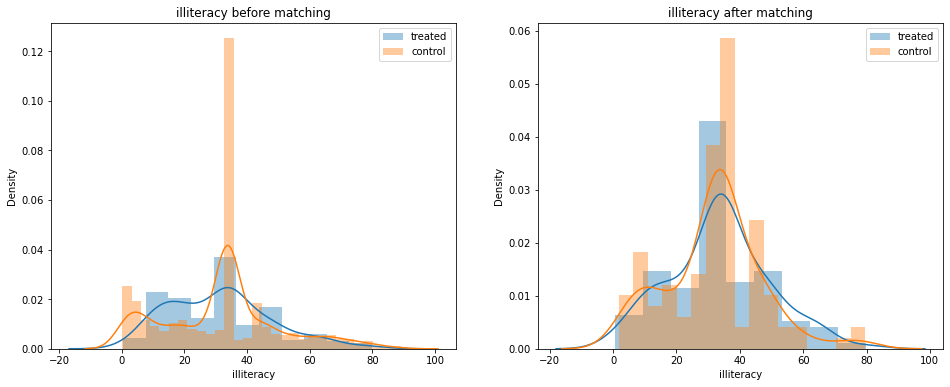

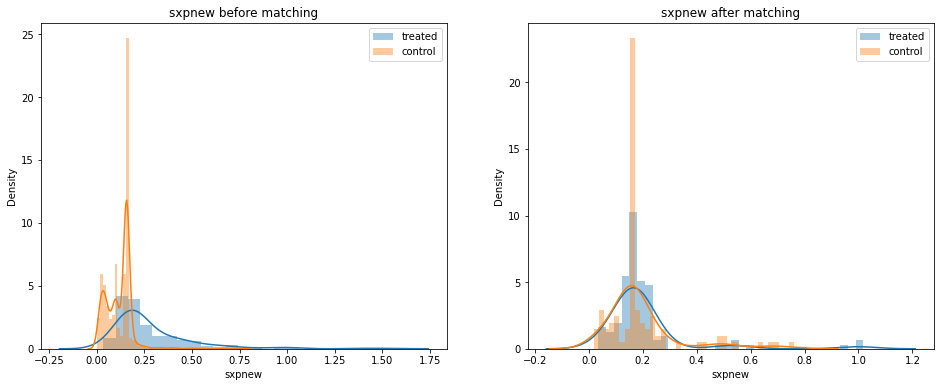

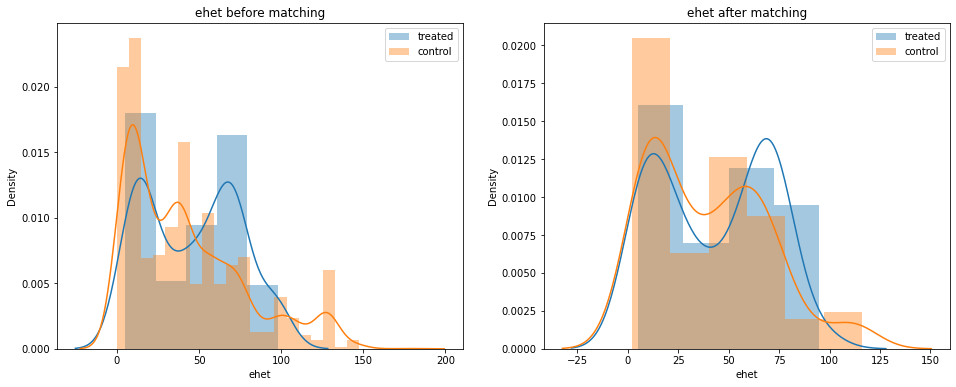

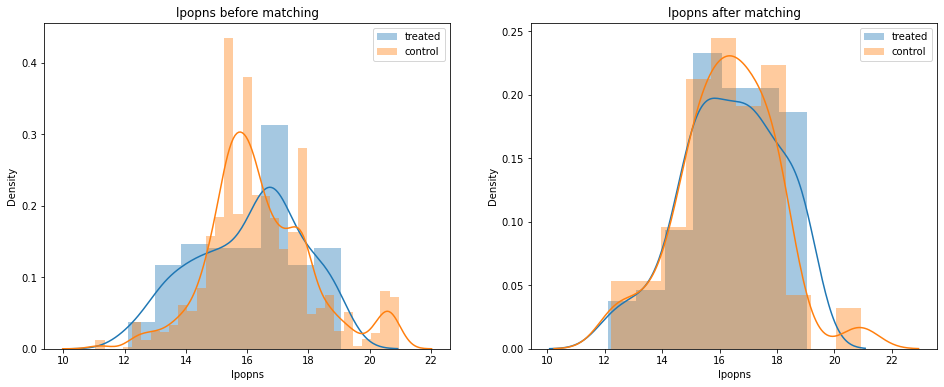

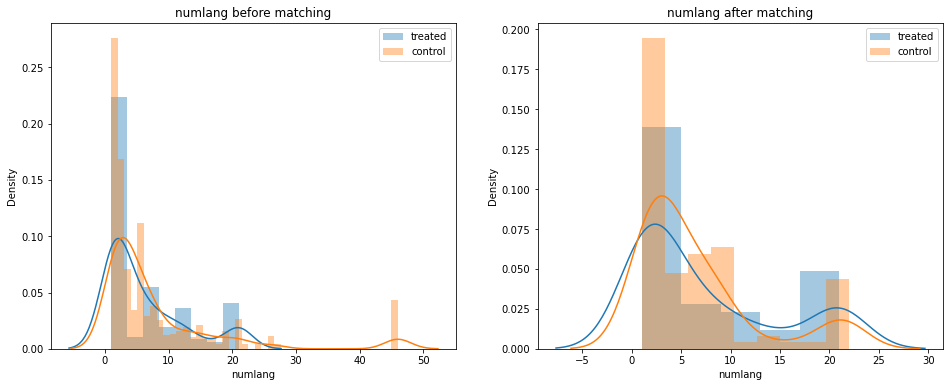

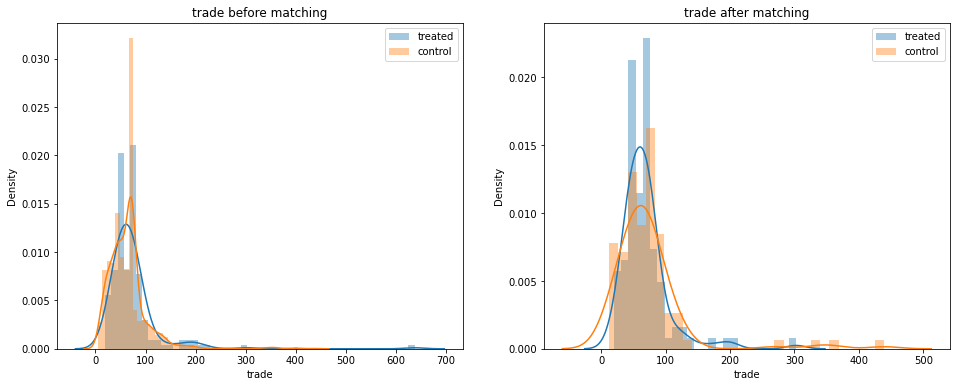

ATE is equal to: 0.157, the 95%-confidence interval is (0.0463,0.269)


In [100]:
matching_analysis(df_gini_clean, 'oil33', feature_imp_gini, feature_names_gini, 
                  "gini.pickle")

In [101]:
matching_analysis(df_gini_clean, 'oil33', feature_imp_gini, feature_names_gini, 
                  "gini.pickle", plothists=False, intense_war=True)

Top variables according to mass threshold:  ['illiteracy', 'sxpnew', 'ehet', 'lpopns', 'numlang', 'trade']
Using formula: oil33 ~ illiteracy + sxpnew + ehet + lpopns + numlang + trade
Optimization terminated successfully.
         Current function value: 0.181015
         Iterations 8
Loading match:  gini.pickle
Number of matched elements: 108
ATE is equal to: 0.213, the 95%-confidence interval is (0.0556,0.361)


Top variables according to mass threshold:  ['illiteracy', 'sxpnew', 'ehet', 'lpopns', 'numlang', 'trade']
Using formula: oil ~ illiteracy + sxpnew + ehet + lpopns + numlang + trade
Optimization terminated successfully.
         Current function value: 0.318383
         Iterations 7
Loading match:  gini_oil.pickle
Number of matched elements: 302
Plotting!


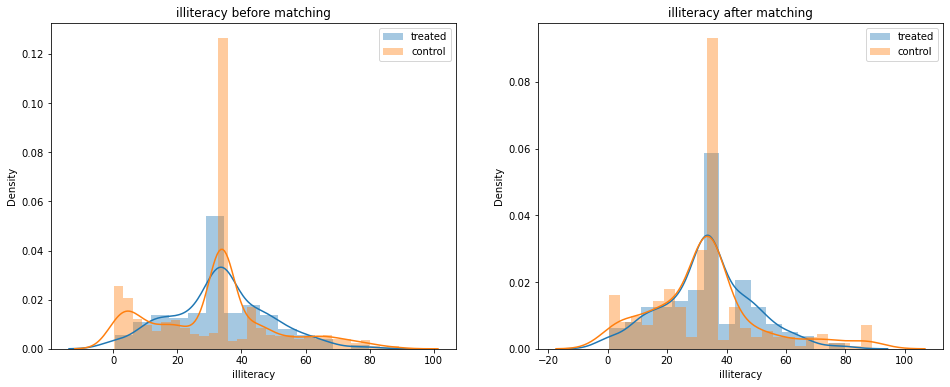

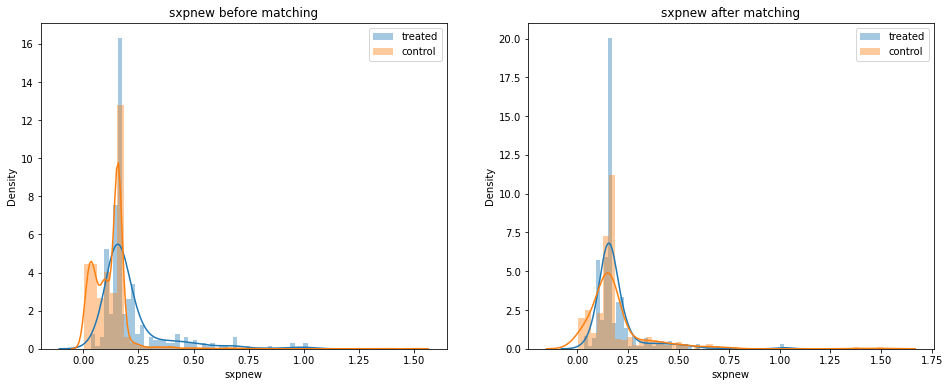

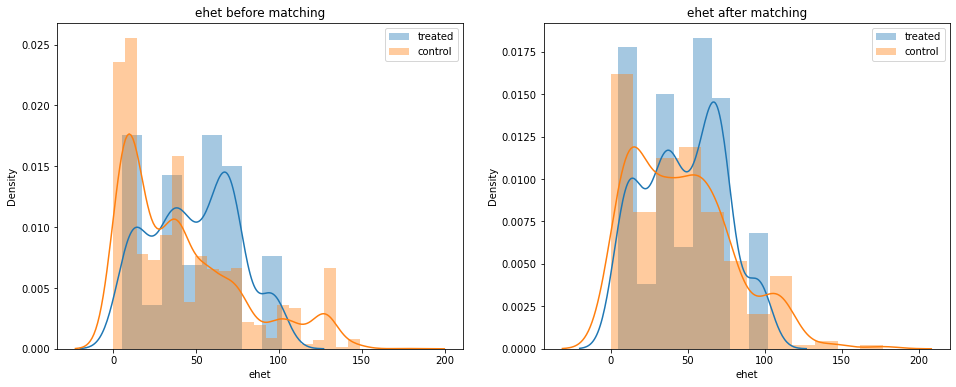

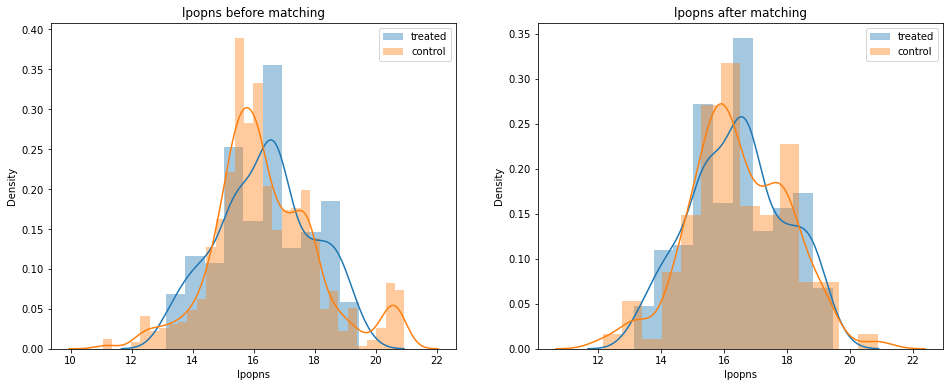

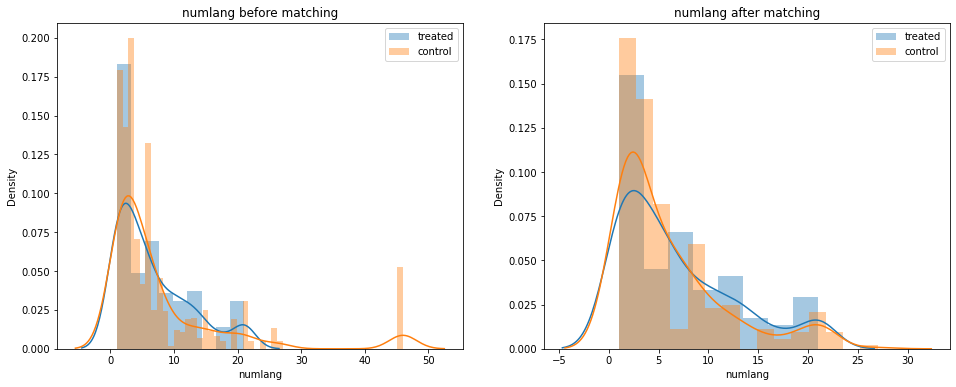

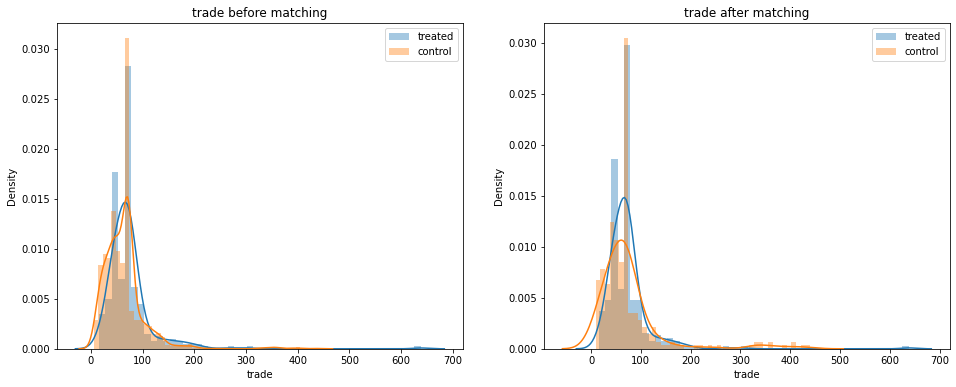

ATE is equal to: 0.185, the 95%-confidence interval is (0.109,0.248)


In [102]:
matching_analysis(df_gini_clean, 'oil', feature_imp_gini, feature_names_gini, 
                  "gini_oil.pickle")

In [103]:
matching_analysis(df_gini_clean, 'oil', feature_imp_gini, feature_names_gini, 
                  "gini_oil.pickle", plothists=False, intense_war=True)

Top variables according to mass threshold:  ['illiteracy', 'sxpnew', 'ehet', 'lpopns', 'numlang', 'trade']
Using formula: oil ~ illiteracy + sxpnew + ehet + lpopns + numlang + trade
Optimization terminated successfully.
         Current function value: 0.318383
         Iterations 7
Loading match:  gini_oil.pickle
Number of matched elements: 302
ATE is equal to: 0.258, the 95%-confidence interval is (0.162,0.358)


In [104]:
df_no_gini[df_no_gini["oil"] == 1].country.unique()

array(['Algeria', 'Angola', 'Azerbaijan', 'Bahrain', 'Bolivia',
       'Cameroon', 'Colombia', 'Congo (Braz)', 'Ecuador', 'Egypt',
       'Gabon', 'Indonesia', 'Iran', 'Iraq', 'Kazakhstan', 'Kuwait',
       'Libya', 'Mexico', 'Nigeria', 'Norway', 'Oman', 'Panama',
       'Saudi Arabia', 'Senegal', 'Singapore', 'Syria',
       'Trinidad and Tobago', 'Tunisia', 'Turkmenistan',
       'Russia (Soviet Union)', 'Russia', 'U.A.R.', 'Venezuela', 'Yemen'],
      dtype=object)

In [105]:
df_gini[df_gini["oil"] == 1].country.unique()

array(['Algeria', 'Angola', 'Azerbaijan', 'Bahrain', 'Bolivia',
       'Cameroon', 'Colombia', 'Congo (Braz)', 'Ecuador', 'Egypt',
       'Gabon', 'Indonesia', 'Iran', 'Iraq', 'Kazakhstan', 'Kuwait',
       'Libya', 'Mexico', 'Nigeria', 'Norway', 'Oman', 'Panama',
       'Saudi Arabia', 'Senegal', 'Singapore', 'Syria',
       'Trinidad and Tobago', 'Tunisia', 'Turkmenistan',
       'Russia (Soviet Union)', 'Russia', 'U.A.R.', 'Venezuela', 'Yemen'],
      dtype=object)

In [106]:
# uncomment to install geopandas

#!pip3 show geopandas
#!if [ "$?" -ne "0" ]; then pip3 install geopandas; fi

# World Maps

In [198]:
gpd_rename = {
    "Bosnia and Herz." : 'Bosnia-Herzegovina',
    'Central African Rep.' : 'C.A.R.',
    'Congo' : 'Congo (Braz)',
    'Czechia' : 'Czech Republic',
    'Côte d\'Ivoire' : 'Ivory Coast',
    'Dem. Rep. Congo' : 'DR Congo (Zaire)',
    'Dominican Rep.' : 'Dominican Republic',
    'Myanmar' : 'Myanmar (Burma)',
    'South Korea' : 'Korea, South',
    'United Arab Emirates' : 'U.A.R.',
    'United Kingdom' : 'U.K.',
    'United States of America' : 'U.S.A.'    
}

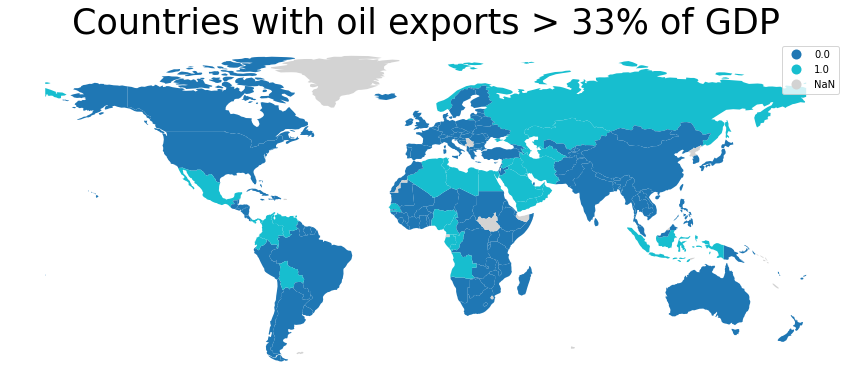

In [212]:
import geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.drop(world[world.name == "Antarctica"].index, inplace=True)
world.name = [gpd_rename.get(x, x) for x in world.name]

oil = joined[["country", "year", "oil"]].groupby("country").max()
world_merged = world.merge(oil[["oil"]], how="left", left_on="name", right_index=True)
world_merged.plot(column="oil", figsize=(15,10), legend=True, categorical=True, missing_kwds={"color" : "lightgrey"}).set_title("Countries with oil exports > 33% of GDP", fontsize=35)
plt.axis('off')
plt.savefig("img/oil_country_map")
plt.show()

# Map of all countries that ever had oil == 1

In [200]:
# Used for renaming

In [201]:
np.setdiff1d(world["name"].unique(), joined.country.unique())

array(['Antarctica', 'Eq. Guinea', 'Falkland Is.',
       'Fr. S. Antarctic Lands', 'Greenland', 'Kosovo', 'Montenegro',
       'N. Cyprus', 'New Caledonia', 'North Korea', 'Palestine',
       'Puerto Rico', 'S. Sudan', 'Serbia', 'Solomon Is.', 'Somaliland',
       'Timor-Leste', 'W. Sahara', 'eSwatini'], dtype=object)

In [202]:
np.setdiff1d(joined.country.unique(), world["name"].unique())

array(['Bahrain', 'Barbados', 'Cape Verde', 'Comoros', 'Czechoslovakia',
       'Grenada', 'Malta', 'Mauritius', 'Russia (Soviet Union)',
       'Seychelles', 'Singapore', 'Solomon Islands', 'South Vietnam',
       'Swaziland', 'Western Samoa', 'Yemen AR', 'Yemen PR', 'Yugoslavia'],
      dtype=object)

In [203]:
# Add USSR, Jugoslavia and Czechoslovakia to war map

ussr = joined[(joined.country == "Russia (Soviet Union)") & (joined.year > 1960)][["country", "year", "war"]].copy()
ussr.loc[:, "country"] = "Russia Kazakhstan Armenia Azerbaijan Belarus Estonia Latvia Lithuania Kyrgyzstan Moldova Tajikistan Turkmenistan Ukraine Uzbekistan"
ussr.country = ussr.country.apply(lambda x : x.split())
ussr = ussr.explode("country")
ussr.reset_index(inplace=True)

yugoslavia = joined[(joined.country == "Yugoslavia") & (joined.year > 1960)][["country", "year", "war"]].copy()
yugoslavia.loc[:, "country"] = "Serbia Croatia Kosovo Montenegro Bosnia-Herzegovina Macedonia Slovenia"
yugoslavia.country = yugoslavia.country.apply(lambda x : x.split())
yugoslavia = yugoslavia.explode("country")
yugoslavia.reset_index(inplace=True)

czechoslovakia = joined[(joined.country == "Czechoslovakia") & (joined.year > 1960)][["country", "year", "war"]].copy()
czechoslovakia.loc[:, "country"] = "Slovakia,Czech Republic"
czechoslovakia.country = czechoslovakia.country.apply(lambda x : x.split(','))
czechoslovakia = czechoslovakia.explode("country")
czechoslovakia.reset_index(inplace=True)

In [204]:
ussr.head()

,index,country,year,war
0,6959,Russia,1961,0
1,6959,Kazakhstan,1961,0
2,6959,Armenia,1961,0
3,6959,Azerbaijan,1961,0
4,6959,Belarus,1961,0


In [205]:
yugoslavia.head()

,index,country,year,war
0,7388,Serbia,1961,0
1,7388,Croatia,1961,0
2,7388,Kosovo,1961,0
3,7388,Montenegro,1961,0
4,7388,Bosnia-Herzegovina,1961,0


In [206]:
czechoslovakia.head()

,index,country,year,war
0,1621,Slovakia,1961,0
1,1621,Czech Republic,1961,0
2,1622,Slovakia,1962,0
3,1622,Czech Republic,1962,0
4,1623,Slovakia,1963,0


In [214]:
# Create dataframe for plotting, with countries, years and wars
war = pd.concat([joined[["country", "year", "war"]], ussr, yugoslavia, czechoslovakia])
war_map = world.merge(war, how="left", left_on="name", right_on="country")
war_map["war_text"] = war_map.war.apply(lambda x : "war" if x else "no war")
war_map_plot = war_map[["name", "war_text", "year", "geometry"]].drop_duplicates().dropna()
war_map_plot.sample(5)

,name,war_text,year,geometry
489,DR Congo (Zaire),no war,1982.0,"POLYGON ((29.34000 -4.49998, 29.51999 -5.41998..."
3544,Iraq,no war,1960.0,"POLYGON ((39.19547 32.16101, 38.79234 33.37869..."
1137,Brazil,no war,1952.0,"POLYGON ((-53.37366 -33.76838, -53.65054 -33.2..."
5207,Lithuania,no war,1997.0,"POLYGON ((26.49433 55.61511, 26.58828 55.16718..."
4760,Armenia,no war,1999.0,"POLYGON ((46.50572 38.77061, 46.14362 38.74120..."


In [215]:
# Create images for gif
for year in war_map_plot.year.unique().astype(int):
    if year < 1961 or year > 2000:
        continue
    print(f"Year: {year}")
    
    ax = war_map_plot[war_map_plot.year == year].plot(column="war_text", 
                                       figsize=(25, 15),
                                       legend=True,
                                       categorical=True,)
                                       #missing_kwds = {"color" : "lightgrey"})
    ax.set_title(f"Countries at war in {year}", fontsize=35)
    plt.axis('off')
    plt.text(-150, -50, str(year), fontdict = {"size" : 35})
    plt.savefig(f"img/gif/war_map_{year}")
    plt.close()

Year: 1970
Year: 1971
Year: 1972
Year: 1973
Year: 1974
Year: 1975
Year: 1976
Year: 1977
Year: 1978
Year: 1979
Year: 1980
Year: 1981
Year: 1982
Year: 1983
Year: 1984
Year: 1985
Year: 1986
Year: 1987
Year: 1988
Year: 1989
Year: 1990
Year: 1991
Year: 1992
Year: 1993
Year: 1994
Year: 1995
Year: 1996
Year: 1997
Year: 1998
Year: 1999
Year: 2000
Year: 1961
Year: 1962
Year: 1963
Year: 1964
Year: 1965
Year: 1966
Year: 1967
Year: 1968
Year: 1969
